<a href="https://colab.research.google.com/github/ejshumaker/SUAutoencoder/blob/master/HSU_autoencoder_cuprite_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from google.colab import output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary
from tqdm import tqdm

from scipy import io

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May 15 17:45:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_dict = io.loadmat("/content/gdrive/My Drive/Research/SpectralUnmixing/CupriteS1_R188.mat")
gt_dict = io.loadmat("/content/gdrive/My Drive/Research/SpectralUnmixing/groundTruth_Cuprite_nEnd12.mat")

## Direct Dataloader

In [0]:
Y = data_dict['Y']
dataset = []
for i in range(Y.shape[0]):
  d = Y[:,i]
  d = d / np.amax(d)
  t = torch.Tensor(d)
  dataset.append(t)
dataloader = DataLoader(dataset)

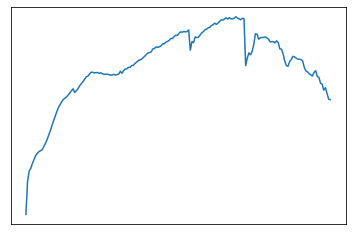

In [8]:
example = dataloader.__iter__().__next__()[0]
plt.plot(example)
plt.xticks([])
plt.yticks([])
plt.show()

## Autoencoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1):
        super(Encoder, self).__init__()

        B = 188 # spectral bands
        R = 12  # endmembers
        self.encoder = nn.Sequential(
            nn.Linear(B, 9*R),
            nn.ReLU(),
            nn.Linear(9*R, 6*R),
            nn.ReLU(),
            nn.Linear(6*R, 3*R),
            nn.ReLU(),
            nn.Linear(3*R, R),
            # nn.ReLU(),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''
        Given a vector x, return the encoded latent representation h.

        Args:
            x: torch.tensor

        Return: 
            h: torch.tensor
        '''
        x = x.unsqueeze(0).unsqueeze(1)
        h = self.encoder(x)

        return h

In [0]:
encoder = Encoder().to(device)
# summary(encoder, [(188)])

In [0]:
class Decoder(nn.Module):
    def __init__(self, out_channels=3, feat_dim=64):
        super(Decoder, self).__init__()

        B = 188 # spectral bands
        R = 12  # endmembers

        self.decoder = nn.Sequential(
          nn.Linear(R,B),
        )

    def forward(self, h):
        '''
        Given encoded vector h, return decoded vector x_hat

        Args:
            h: torch.tensor

        Return: 
            x_hat: torch.tensor
        '''
        return x_hat

In [0]:
decoder = Decoder().to(device)
# summary(decoder, [(12)])

In [0]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels=3, feat_dim=64):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(in_channels=1)
        self.decoder = Decoder()

    def forward(self, x):
        '''
        Compress and reconstruct the input image with encoder and decoder.

        Args:
            x: torch.tensor

        Return: 
            x_: torch.tensor
        '''

        h = self.encoder(x.to(device))
        x_hat = self.decoder(h)

        return x_hat, h

In [0]:
ae = Autoencoder().to(device)
# summary(ae, (3, 64, 64))

In [0]:
def visualize_recon(model, dataloader):
    '''
    Helper function for visualizing reconstruction performance.

    Randomly sample 8 images and plot the original/reconstructed images. 
    '''
    model.eval()

    inp_img = []
    out_img = []
    for i,img in enumerate(dataloader):
      if (i < 5):
        inp_img.append(img)
        out_img.append(model(img)[0].squeeze(0).squeeze(0).detach().cpu())

    fig, ax = plt.subplots(2,5, figsize=(15,5))
    ax[0,0].plot(inp_img[0][0])
    ax[0,1].plot(inp_img[1][0])
    ax[0,2].plot(inp_img[2][0])
    ax[0,3].plot(inp_img[3][0])
    ax[0,4].plot(inp_img[4][0])

    ax[1,0].plot(out_img[0][0])
    ax[1,1].plot(out_img[1][0])
    ax[1,2].plot(out_img[2][0])
    ax[1,3].plot(out_img[3][0])
    ax[1,4].plot(out_img[4][0])

    model.train()
    plt.show()

In [0]:
def train_ae(model, dataloader, epochs=100):
    '''
    Train autoencoder model.

    Args:
        model: torch.nn.module.
        dataloader: DataLoader. The unlabeled partition of the STL dataset.
    '''

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    loss_traj = []

    for epoch in tqdm(range(epochs)):

        loss_epoch = 0
        for x in dataloader:

            inp = x[0].to(device)

            out,h = model(inp)

            loss = criterion(out, inp.unsqueeze(0).unsqueeze(1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        
        if epoch % 10 == 0:
            output.clear()
            print('\nEpoch {}, loss {:.3f}'.format(epoch, loss_epoch))
            visualize_recon(model, dataloader)

    return model, loss_traj, out, inp


Epoch 90, loss 0.089


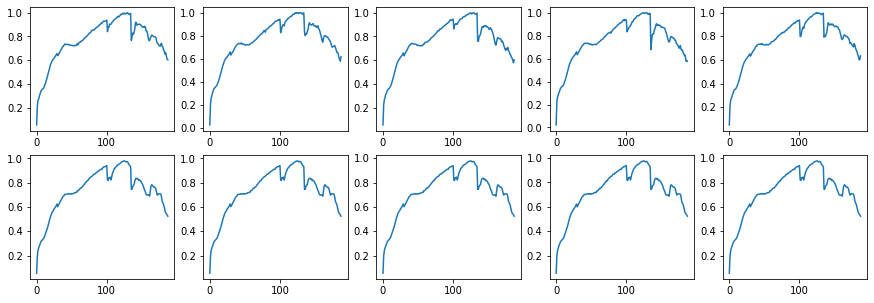


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


In [203]:
# Train the autoencoder for 100 epochs
ae = Autoencoder().to(device)
model,_,_,_ = train_ae(ae, dataloader, epochs=100)

### Get M and S from LMM: X = MS

In [0]:
noise = True
B = 188
R = 12
# Get decoder output weights, M
for layer in model.modules():
  if isinstance(layer, nn.Softmax):
    print('Softmax:', layer)
  if isinstance(layer, nn.Linear):
    if (layer.out_features == B):
      M = layer.weight.detach().cpu().numpy()

In [0]:
# Run model on test image 170
model.eval()
for i,img in enumerate(dataloader):
  if i == 170:
    inp = img[0]
x_hat, h = model(inp)
# Set hidden activations h_i to S
S = h.squeeze(0).detach().cpu().numpy()[0]

In [0]:
if noise:
  X = (M @ S) + np.random.normal(0.2,0.01,M.shape[0]) # with noise
else:
  X = (M @ S) # without noise

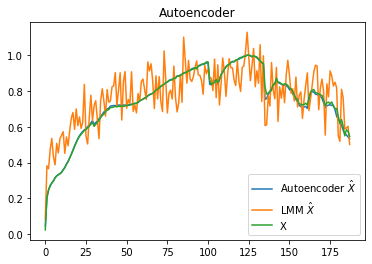

In [343]:
x = x_hat.squeeze(0).squeeze(0).detach().cpu().numpy()
plt.plot(x, label='Autoencoder $\hat{X}$')
plt.plot(X, label='LMM $\hat{X}$')
plt.plot(inp, label = 'X')
plt.legend()
plt.title('Autoencoder')
plt.show()

In [0]:
# Run model on all pixels
model.eval()
length = 0
S_avg = np.zeros(R)
for i, img in enumerate(dataloader):
    inp = img[0]
    _, h = model(inp)
    S_avg += h.squeeze(0).detach().cpu().numpy()[0]
    length = i + 1
S_avg = S_avg / length

In [0]:
gt = gt_dict['M']
gt_abundances = np.sum(gt, axis=0)
total = np.sum(gt_abundances)
gt_abundances = gt_abundances / total

In [351]:
print('Abundances:\n', S)
print('============================================================================================')
print('Abundances Avg:\n', S_avg)
print('============================================================================================')
print('Ground Truth Abundances:\n',gt_abundances)

Abundances:
 [-0.0990359   0.4592273  -0.28225076  0.21033016  0.1973326  -0.19621414
  0.29854077 -0.34390396  0.46742108 -0.34736082 -0.14104617  0.37848032]
Abundances Avg:
 [ 0.02285733  0.3533031  -0.16279823  0.24880881  0.14896484 -0.11179987
  0.16336717 -0.28375451  0.37092252 -0.23230046 -0.02030415  0.28101561]
Ground Truth Abundances:
 [0.10510476 0.11231181 0.08147431 0.09446176 0.06403207 0.0794122
 0.09723979 0.08763809 0.05719462 0.09152212 0.04369934 0.08590915]
